In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from functools import reduce
import seaborn as sns

plt.style.use("ggplot")

# settings
data_root = '/home/jma/Python3.7/Cubist_2021_11'

dtcol = 'pos_date'
seccol = 'security_id'
start_date = '2010-07-01'
scorecol = 'd3'

## from Spearman rank correlation, d7 has negative IC with fwdretf1, similar magnituide as d9 

big_df = pd.read_csv(os.path.join(data_root, 'known_df_on_data_date.csv.gz'),
                    parse_dates=[dtcol], dtype={seccol: str}, 
                    usecols=[dtcol, seccol, scorecol, 'clip_trisk', 'fwdret_f1', 'sector', 'in_trading_universe'])

  security_id  d3   pos_date  fwdret_f1 in_trading_universe  \
0     1000201 NaN 2010-01-05   0.061447                   N   
1     1004601 NaN 2010-01-05  -0.018519                   N   
2      100701 NaN 2010-01-05  -0.015715                   Y   
3     1007201 NaN 2010-01-05   0.036733                   Y   
4     1009601 NaN 2010-01-05  -0.011088                   N   

                   sector  clip_trisk  
0  Consumer Discretionary         NaN  
1  Information Technology         NaN  
2               Utilities         NaN  
3  Consumer Discretionary         NaN  
4        Consumer Staples         NaN  
security_id                    object
d3                            float64
pos_date               datetime64[ns]
fwdret_f1                     float64
in_trading_universe            object
sector                         object
clip_trisk                    float64
dtype: object
       security_id        d3   pos_date  fwdret_f1 in_trading_universe  \
351351     2972501  0.05212

<AxesSubplot:xlabel='pos_date'>

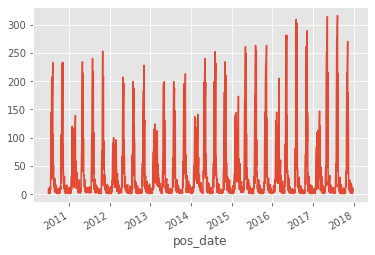

In [2]:
print(big_df.head())
print(big_df.dtypes)

big_df = big_df.loc[big_df[dtcol] >= start_date].dropna(subset=[scorecol])

print(big_df.head())
big_df.groupby(dtcol).size().plot()

In [3]:
big_df[scorecol].describe()

count    68438.000000
mean         0.015124
std          1.291640
min       -243.046958
25%         -0.009850
50%          0.031470
75%          0.060588
max        124.536741
Name: d3, dtype: float64

In [4]:
rsch_universe = big_df.loc[big_df['in_trading_universe'] == 'Y', ['pos_date', seccol]].copy()

In [5]:
big_df = big_df.merge(rsch_universe)

In [6]:
print(big_df.head(), '\n')
print(big_df.tail())

  security_id        d3   pos_date  fwdret_f1 in_trading_universe  \
0     2972501  0.052122 2010-07-01  -0.000847                   Y   
1     8262901  0.054516 2010-07-01  -0.033682                   Y   
2      199401  0.072863 2010-07-02   0.036063                   Y   
3     4260001  0.111193 2010-07-02   0.053241                   Y   
4     4765001  0.015118 2010-07-02   0.008453                   Y   

             sector  clip_trisk  
0  Consumer Staples   20.671667  
1         Materials   44.628161  
2       Industrials   35.513271  
3       Industrials   34.146874  
4         Materials   26.791100   

      security_id        d3   pos_date  fwdret_f1 in_trading_universe  \
49239     2972501  0.057463 2017-12-22  -0.000166                   Y   
49240     4705401  0.050315 2017-12-22   0.028985                   Y   
49241     5971101  0.204322 2017-12-22  -0.027586                   Y   
49242     8224401  0.059910 2017-12-22   0.022143                   Y   
49243      883

In [7]:
def wins_qnt_score(df, scorecol, dtcol, qmin=0.05, qmax=0.95):
    def _helper(x):
        l, u = np.nanquantile(x, qmin), np.quantile(x, qmax)
        x[x >= u] = u
        x[x <= l] = l
        return x
    return df.groupby(dtcol)[scorecol].transform(_helper)

def std_qnt_score(df, scorecol, dtcol, demean=True):
    return df.groupby(dtcol)[scorecol].transform(lambda x: (x - x.mean()) / x.std())

In [8]:
big_df['score'] = wins_qnt_score(big_df, scorecol, 'pos_date')
big_df['score'] = std_qnt_score(big_df, 'score', 'pos_date', demean=True)

In [9]:
def quickstats(df, scorecol, riskcol, riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id'):
    
    df = df.copy()
    
    
    ### get portfolio performance stats
    df['hld'] = df[scorecol] / np.power(df[riskcol], riskpower)
    df['hld_wgt'] =df.groupby(dtcol)['hld'].transform(lambda x: x / x.abs().sum())
    
    df['attr_fwdretf1'] = df['hld_wgt'] * df[retcol]
    xxx = df.groupby(dtcol, as_index=False)['attr_fwdretf1'].apply(lambda x: x.sum())
    xxx['year'] = xxx['pos_date'].dt.year
    
    ann_stats = xxx.groupby('year')['attr_fwdretf1'].apply(
        lambda x: pd.Series([x.mean() * 252, x.std() * np.sqrt(252), x.shape[0]],
                            index=['AnnRet', 'AnnVol', 'Days'])).unstack()
    ann_stats['AnnSR'] = ann_stats['AnnRet'] / ann_stats['AnnVol']
    
    ### 
    ncount = df.groupby(dtcol, as_index=False)[scorecol].size()
    ncount['year'] = ncount[dtcol].dt.year
    ncount = ncount.groupby('year').mean().astype(int)
    
    xxx.set_index(dtcol)['attr_fwdretf1'].cumsum().plot(title=f'score={scorecol}')
    return xxx.drop(['year'], axis=1), pd.concat([ann_stats.round(4), ncount], axis=1)

      AnnRet  AnnVol   Days   AnnSR  size
year                                     
2010 -0.0203  0.0965  117.0 -0.2108    25
2011  0.1596  0.1108  230.0  1.4412    25
2012  0.1672  0.0962  222.0  1.7379    22
2013  0.1297  0.0895  232.0  1.4484    25
2014  0.1447  0.1010  233.0  1.4325    31
2015  0.1998  0.1176  233.0  1.6989    31
2016  0.1324  0.1268  233.0  1.0442    31
2017 -0.0519  0.1122  227.0 -0.4632    32


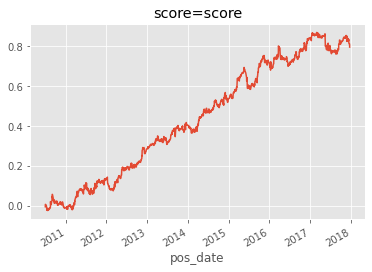

In [10]:
_, stats = quickstats(big_df, 'score', 'clip_trisk')
print(stats)

<AxesSubplot:>

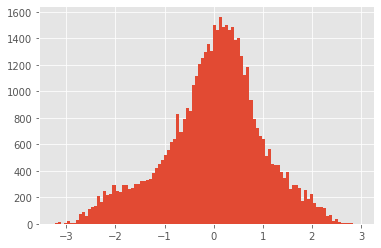

In [16]:
big_df['score'].hist(bins=100)

In [18]:
big_df[['score', 'd3']].corr(method='spearman')

score       d3
score  1.00000  0.90335
d3     0.90335  1.00000

2.4186791228087654


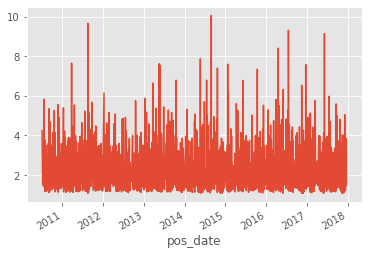

In [13]:
ptable = pd.pivot_table(big_df, index=dtcol, columns=seccol, values='score')
ptable.fillna(0, inplace=True)
to = ptable.diff(1).abs().sum(axis=1) / ptable.shift(1).abs().sum(axis=1)
to.plot()
print(to.mean())

In [14]:
241 * 252 * 0.0001

6.0732

In [28]:
ptable = pd.pivot_table(big_df, index=dtcol, columns=seccol, values='score')
ptable.fillna(0, inplace=True)

In [34]:
print(ptable.head()['2972501'].diff(1))
print(ptable.head()['2972501'])

pos_date
2010-07-01         NaN
2010-07-02    0.707107
2010-07-08    0.000000
2010-07-12    0.000000
2010-07-14    0.000000
Name: 2972501, dtype: float64
pos_date
2010-07-01   -0.707107
2010-07-02    0.000000
2010-07-08    0.000000
2010-07-12    0.000000
2010-07-14    0.000000
Name: 2972501, dtype: float64


In [26]:
big_df.head()

security_id        d3   pos_date  fwdret_f1 in_trading_universe  \
0     2972501  0.052122 2010-07-01  -0.000847                   Y   
1     8262901  0.054516 2010-07-01  -0.033682                   Y   
2      199401  0.072863 2010-07-02   0.036063                   Y   
3     4260001  0.111193 2010-07-02   0.053241                   Y   
4     4765001  0.015118 2010-07-02   0.008453                   Y   

             sector  clip_trisk     score  
0  Consumer Staples   20.671667 -0.707107  
1         Materials   44.628161  0.707107  
2       Industrials   35.513271  0.140074  
3       Industrials   34.146874  1.117361  
4         Materials   26.791100 -1.281673

<AxesSubplot:xlabel='pos_date'>

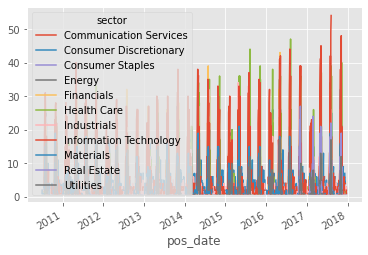

In [16]:
big_df.groupby(['pos_date', 'sector']).size().unstack(level=1).plot()